8-1 합성곱 연산에 대해 알아봅니다

In [ ]:
import numpy as np
w = np.array([2,1,5,3])
x = np.array([2, 8, 3, 7, 1, 2, 0, 4, 5])

In [ ]:
w_r = np.flip(w)
print(w_r)

[3 5 1 2]


In [ ]:
for i in range(6):
  print(np.dot(x[i:i+4], w_r))

63
48
49
28
21
20


In [ ]:
from scipy.signal import convolve
convolve(x, w, mode='valid')

array([63, 48, 49, 28, 21, 20])

In [ ]:
from scipy.signal import correlate
correlate(x, w, mode='valid')

array([48, 57, 24, 25, 16, 39])

In [ ]:
correlate(x, w, mode='full')

array([ 6, 34, 51, 48, 57, 24, 25, 16, 39, 29, 13, 10])

In [ ]:
correlate(x, w, mode='same')

array([34, 51, 48, 57, 24, 25, 16, 39, 29])

In [ ]:
x = np.array([[1,2,3],
             [4,5,6],
             [7,8,9]])
w = np.array([[2, 0], [0, 0]])
from scipy.signal import correlate2d
correlate2d(x, w, mode='valid')

array([[ 2,  4],
       [ 8, 10]])

In [ ]:
correlate2d(x, w, mode='same')

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

In [ ]:
import tensorflow as tf
x_4d = x.astype(np.float).reshape(1, 3, 3, 1)
w_4d = w.reshape(2, 2, 1, 1)

In [ ]:
c_out = tf.nn.conv2d(x_4d, w_4d, strides=1, padding='SAME')

In [ ]:
c_out.numpy().reshape(3, 3)

array([[ 2.,  4.,  6.],
       [ 8., 10., 12.],
       [14., 16., 18.]])

8-2 풀링 연산에 대해 알아봅니다





In [ ]:
x = np.array([[1,2,3,4],
              [5,6,7,8],
              [9,10,11,12],
              [13,14,15,16]])
x = x.reshape(1,4,4,1)

In [ ]:
p_out = tf.nn.max_pool2d(x, ksize=2, strides=2, padding='VALID')
p_out.numpy().reshape(2, 2)

array([[ 6.,  8.],
       [14., 16.]], dtype=float32)

8-3 합성곱 신경망의 구조를 알아봅니다

In [ ]:
def relu(x):
  return np.maximum(x, 0)

In [ ]:
x = np.array([-1,2,-3,4,-5])
relu(x)

array([0, 2, 0, 4, 0])

In [ ]:
r_out = tf.nn.relu(x)
r_out.numpy()

array([0, 2, 0, 4, 0])

8-4 합성곱 신경망을 만들고 훈련합니다

In [ ]:
class ConvolutionNetwork:

  def __init__(self, n_kernels=10, units=10, batch_size=32, learning_rate=0.1):
    self.n_kernels = n_kernels
    self.kernel_size = 3
    self.optimizer = None
    self.conv_w = None
    self.conv_b = None
    self.units = units
    self.batch_size = batch_size
    self.w1 = None
    self.b1 = None
    self.w2 = None
    self.b2 = None
    self.a1 = None
    self.losses = []
    self.val_losses = []
    self.lr = learning_rate

  def forpass(self, x):
    c_out = tf.nn.conv2d(x, self.conv_w, strides=1, padding='SAME') + self.conv_b
    r_out = tf.nn.relu(c_out)
    p_out = tf.nn.max_pool2d(r_out, ksize=2, strides=2, padding='VALID')
    f_out = tf.reshape(p_out, [x.shape[0], -1])
    z1 = tf.matmul(f_out, self.w1) + self.b1
    a1 = tf.nn.relu(z1)
    z2 = tf.matmul(a1, self.w2) + self.b2
    return z2

  def init_weights(self, input_shape, n_classes):
      g = tf.initializers.glorot_uniform()
      self.conv_w = tf.Variable(g((3, 3, 1, self.n_kernels)))
      self.conv_b = tf.Variable(np.zeros(self.n_kernels), dtype=float)
      n_features = 14 * 14 * self.n_kernels 
      self.w1 = tf.Variable(g((n_features, self.units)))
      self.b1 = tf.Variable(np.zeros(self.units), dtype=float)
      self.w2 = tf.Variable(g((self.units, n_classes)))
      self.b2 = tf.Variable(np.zeros(n_classes), dtype=float)

  def fit(self, x, y, epochs=100, x_val=None, y_val=None):
    self.init_weights(x.shape, y.shape[1])
    self.optimizer = tf.optimizers.SGD(learning_rate=self.lr)
    for i in range(epochs):
      print('에포크', i, end=' ')
      batch_losses = []
      for x_batch, y_batch in self.gen_batch(x, y):
        print('.', end='')
        self.training(x_batch, y_batch)
        batch_losses.append(self.get_loss(x_batch, y_batch))
      print()
      self.losses.append(np.mean(batch_losses))
      self.val_losses.append(self.get_loss(x_val, y_val))

  def gen_batch(self, x, y):
    bins = len(x) // self.batch_size
    indexes = np.random.permutation(np.arange(len(x)))
    x = x[indexes]
    y = y[indexes]
    for i in range(bins):
      start = self.batch_size * i
      end = self.batch_size * (i + 1)
      yield x[start:end], y[start:end]

  def training(self, x, y):
    m = len(x)
    with tf.GradientTape() as tape:
      z = self.forpass(x)

      loss = tf.nn.softmax_cross_entropy_with_logits(y, z)
      loss = tf.reduce_mean(loss)

    weights_list = [self.conv_w, self.conv_b, self.w1, self.b1, self.w2, self.b2]

    grads = tape.gradient(loss, weights_list)
    self.optimizer.apply_gradients(zip(grads, weights_list))

  def predict(self, x):
    z = self.forpass(x)
    return np.argmax(z.numpy(), axis=1)

  def score(self, x, y):
    return np.mean(self.predict(x) == np.argmax(y, axis=1))

  def get_loss(self, x, y):
    z = self.forpass(x)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, z))
    return loss.numpy()

In [ ]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                  stratify=y_train_all, test_size=0.2,
                                                  random_state=42)

In [ ]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [ ]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)

In [ ]:
x_train.shape

(48000, 28, 28, 1)

In [ ]:
x_train = x_train / 255
x_val = x_val / 255

In [ ]:
cn = ConvolutionNetwork(n_kernels=10, units=100, batch_size=128, learning_rate=0.01)
cn.fit(x_train, y_train_encoded, x_val=x_val, y_val=y_val_encoded, epochs=20)

에포크 0 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 1 .......................................................................................................................................................................................................................................................................................................................................................................................
에포크 2 ......................................................................................................................................................................................................................................

In [ ]:
import matplotlib.pyplot as plt

plt.plot(cn.losses)
plt.plot(cn.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss' , 'val_loss'])
plt.show()

In [ ]:
cn.score(x_val, y_val_encoded)

0.8798333333333334

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
conv1 = tf.keras.Sequential()
conv1.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))

In [ ]:
conv1.add(MaxPooling2D(2, 2))

In [ ]:
conv1.add(Flatten())

In [ ]:
conv1.add(Dense(100, activation='relu'))
conv1.add(Dense(10, activation='softmax'))

In [ ]:
conv1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 10)        0         
_________________________________________________________________
flatten (Flatten)            (None, 1960)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               196100    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
_________________________________________________________________


In [ ]:
conv1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = conv1.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 23s 15ms/step - loss: 0.5977 - accuracy: 0.7977 - val_loss: 0.3183 - val_accuracy: 0.8867
Epoch 2/20
1500/1500 [==============================] - 22s 15ms/step - loss: 0.2982 - accuracy: 0.8915 - val_loss: 0.2762 - val_accuracy: 0.9003
Epoch 3/20
1500/1500 [==============================] - 22s 15ms/step - loss: 0.2502 - accuracy: 0.9091 - val_loss: 0.2666 - val_accuracy: 0.9062
Epoch 4/20
1500/1500 [==============================] - 27s 18ms/step - loss: 0.2253 - accuracy: 0.9184 - val_loss: 0.2567 - val_accuracy: 0.9085
Epoch 5/20
1500/1500 [==============================] - 22s 15ms/step - loss: 0.1951 - accuracy: 0.9290 - val_loss: 0.2530 - val_accuracy: 0.9080
Epoch 6/20
1500/1500 [==============================] - 22s 15ms/step - loss: 0.1770 - accuracy: 0.9339 - val_loss: 0.2405 - val_accuracy: 0.9158
Epoch 7/20
1500/1500 [==============================] - 22s 15ms/step - loss: 0.1558 - accuracy: 0.9434 - val_loss: 0.2469 -

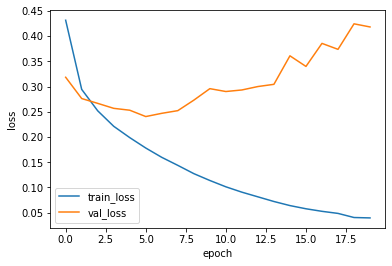

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: The handle 'i' has a label of '_' which cannot be automatically added to the legend.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Legend does not support 't' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artis

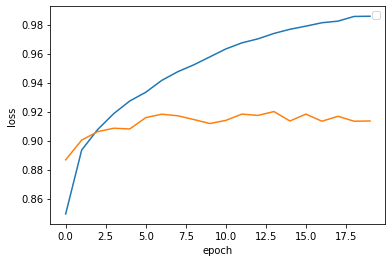

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend('train_accuracy', 'val_accuracy')
plt.show()

In [ ]:
from tensorflow.keras.layers import Dropout

conv2 = tf.keras.Sequential()
conv2.add(Conv2D(10, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)))
conv2.add(MaxPooling2D((2, 2)))
conv2.add(Flatten())
conv2.add(Dropout(0.5))
conv2.add(Dense(100, activation='relu'))
conv2.add(Dense(10, activation='softmax'))

In [ ]:
conv2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 10)        100       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1960)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1960)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               196100    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 197,210
Trainable params: 197,210
Non-trainable params: 0
________________________________________________

In [ ]:
conv2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = conv2.fit(x_train, y_train_encoded, epochs=20, validation_data=(x_val, y_val_encoded))

Epoch 1/20
1500/1500 [==============================] - 24s 16ms/step - loss: 0.6885 - accuracy: 0.7547 - val_loss: 0.3498 - val_accuracy: 0.8774
Epoch 2/20
1500/1500 [==============================] - 23s 15ms/step - loss: 0.3872 - accuracy: 0.8621 - val_loss: 0.3055 - val_accuracy: 0.8934
Epoch 3/20
1500/1500 [==============================] - 23s 15ms/step - loss: 0.3375 - accuracy: 0.8780 - val_loss: 0.2881 - val_accuracy: 0.8938
Epoch 4/20
1500/1500 [==============================] - 23s 15ms/step - loss: 0.3130 - accuracy: 0.8835 - val_loss: 0.2810 - val_accuracy: 0.8978
Epoch 5/20
1500/1500 [==============================] - 23s 15ms/step - loss: 0.2932 - accuracy: 0.8918 - val_loss: 0.2671 - val_accuracy: 0.9034
Epoch 6/20
1500/1500 [==============================] - 23s 15ms/step - loss: 0.2700 - accuracy: 0.8977 - val_loss: 0.2485 - val_accuracy: 0.9100
Epoch 7/20
1500/1500 [==============================] - 23s 16ms/step - loss: 0.2563 - accuracy: 0.9044 - val_loss: 0.2425 -

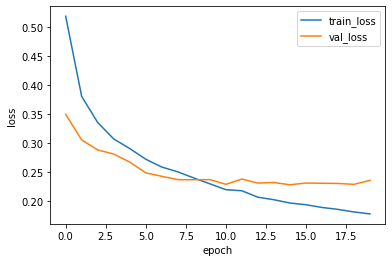

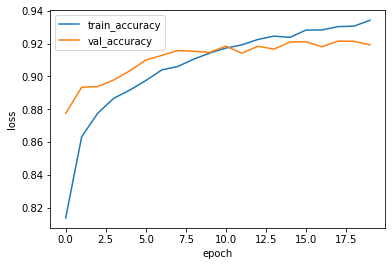

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()